## Advanced Lane Finding Project

## Camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact
import matplotlib.image as mpimg

%matplotlib inline

plt.rcParams['figure.figsize'] = [10,6]

### Compute object and image points 

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

processed_images = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        processed_images.append(img)     



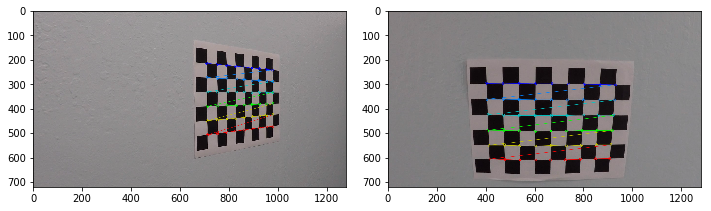

In [6]:
 #display images
ncols = 2
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.tight_layout()

axes[0].imshow(processed_images[0])
axes[1].imshow(processed_images[1])      
plt.show()

### Calibrate Camera

In [7]:
#Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [8]:
#Undistort an RGB image
def undistort(image):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [9]:
def bgr2rgb(image):
    return image[...,::-1]

In [10]:
#undistort test images
test_images = glob.glob('test_images/*.jpg')
original_test_images = []
undistorted_test_images = []
for fname in test_images:
    img = cv2.imread(fname)
    img = bgr2rgb(img)
    original_test_images.append(img)
    undistorted_test_images.append(undistort(img))    

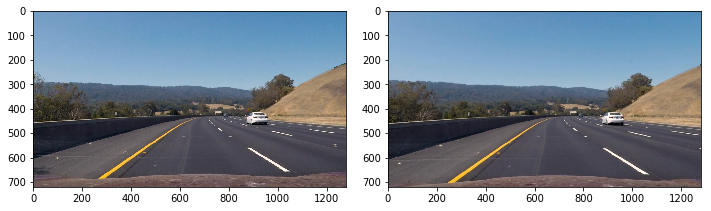

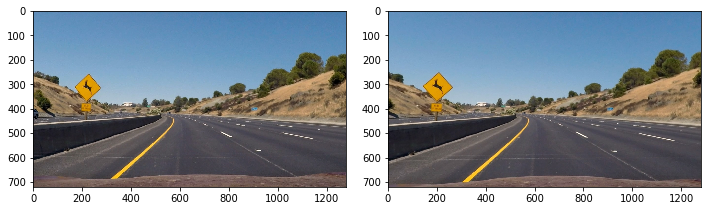

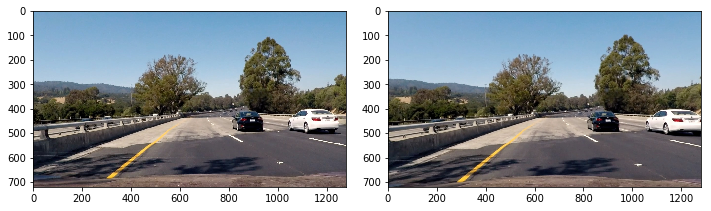

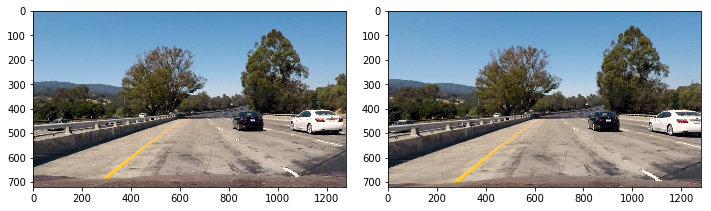

In [11]:
for original, undistorted in zip(original_test_images[:4], undistorted_test_images[:4]):
    ncols = 2
    nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()

    axes[0].imshow(original)
    axes[1].imshow(undistorted)      
    plt.show()

## Thresholded Binary Image

### Gradient Threshold

In [12]:
#The function takes in an RGB image, gradient orientation, and threshold min / max values.
# Returns thresholded image
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh = (0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [13]:
# The function returns the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [14]:
# The function thresholds an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [15]:
def combined_threshold(image, kernel_size=3, 
                       x_thresh=(0,255), 
                       y_thresh=(0,255), 
                       mag_thresh=(0,255), 
                       dir_thresh=(0, np.pi/2)):
    gradx = abs_sobel_threshold(image, orient='x', sobel_kernel=kernel_size, thresh=x_thresh)
    grady = abs_sobel_threshold(image, orient='y', sobel_kernel=kernel_size, thresh=y_thresh)
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    

In [16]:
def get_grad_threshold(image):
    return abs_sobel_threshold(image, sobel_kernel=21, thresh=(30,130))

In [17]:
grad_thresholded_imgs = []
for image in undistorted_test_images:        
    #thresh_img = combined_threshold(image, kernel_size=15, x_thresh=(30,100), y_thresh=(50,130), 
    #                                mag_thresh=(30,100), dir_thresh=(0.9, 1.1))
    thresh_img = get_grad_threshold(image)
    
    grad_thresholded_imgs.append(thresh_img)    

In [ ]:
def display_images_compare(images_a, images_b):
    #display images
    ncols = 2
    nrows = len(images_a)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()

    count = 0
    for i in range(nrows):
            axes[i][0].imshow(images_a[count])
            axes[i][1].imshow(images_b[count], cmap='gray')
            count += 1

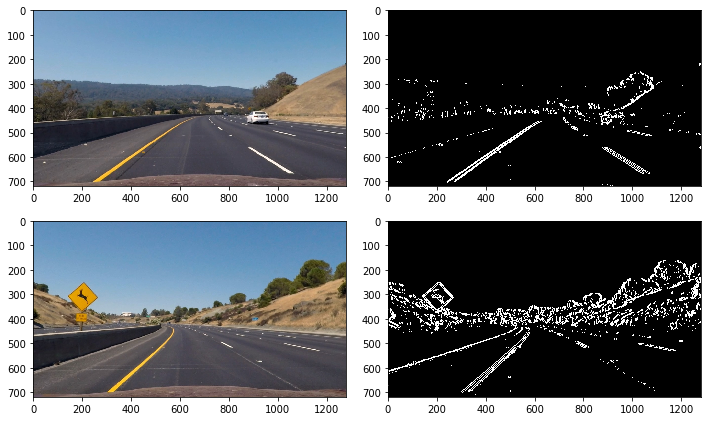

In [18]:
display_images_compare(undistorted_test_images[:2], grad_thresholded_imgs[:2])

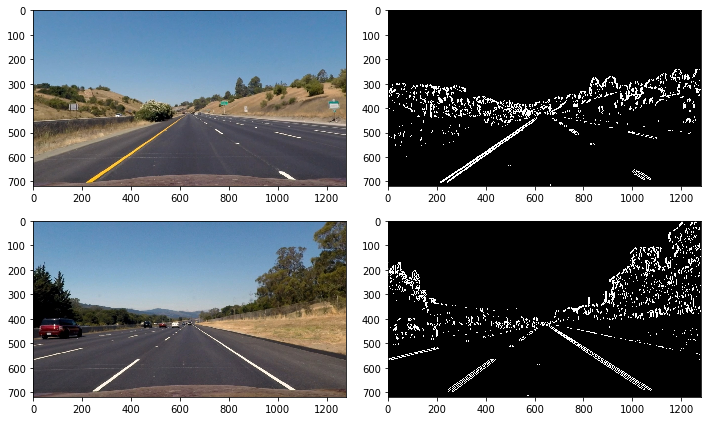

In [19]:
display_images_compare(undistorted_test_images[4:6], grad_thresholded_imgs[4:6])

### Color Threshold

In [20]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [21]:
def get_color_threshold(image):
    return hls_select(image, thresh=(170,255))

In [22]:
color_thresholded_imgs = []
for image in undistorted_test_images:        
    thresh_img = get_color_threshold(image)
    color_thresholded_imgs.append(thresh_img)    

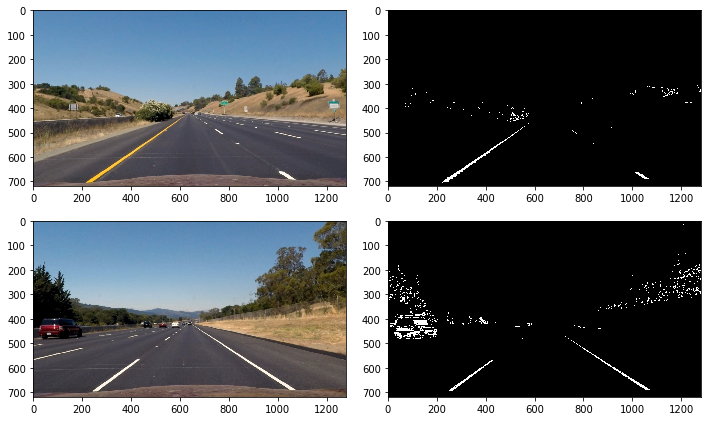

In [23]:
display_images_compare(undistorted_test_images[4:6], color_thresholded_imgs[4:6])

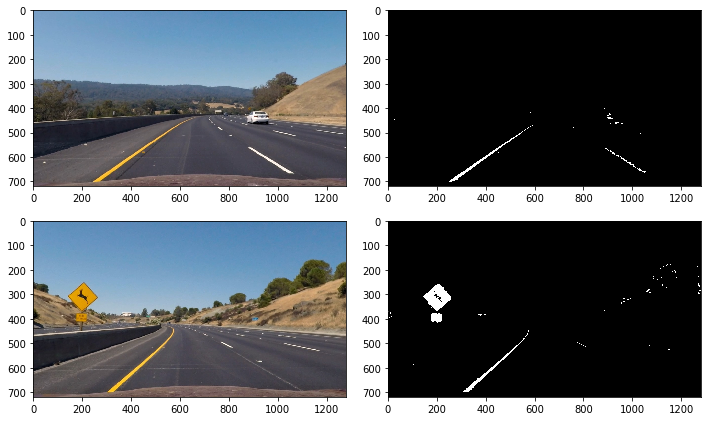

In [24]:
display_images_compare(undistorted_test_images[0:2], color_thresholded_imgs[0:2])

### Combine Color and Gradient Thresholds

In [25]:
# Combine the two binary thresholds: gradient and color
def combine_grad_color_threshold(grad, color):
    color_binary = np.dstack(( np.zeros_like(grad), grad, color)) * 255
    combined_binary = np.zeros_like(grad)
    combined_binary[(grad == 1) | (color == 1)] = 1
    return combined_binary

In [26]:
#Get combined gradient and color threshold from an image
def get_cobmined_threshold(image):
    grad = get_grad_threshold(image)
    color = get_color_threshold(image)
    return combine_grad_color_threshold(grad, color)    

In [27]:
color_binary_imgs = []
combined_binary_imgs = []
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
for grad, color in zip(grad_thresholded_imgs, color_thresholded_imgs):
    
    color_binary = np.dstack(( np.zeros_like(grad), grad, color)) * 255
    color_binary_imgs.append(color_binary)

    # Combine the two binary thresholds
    combined_binary = combine_grad_color_threshold(grad, color)
    
    combined_binary_imgs.append(combined_binary)   


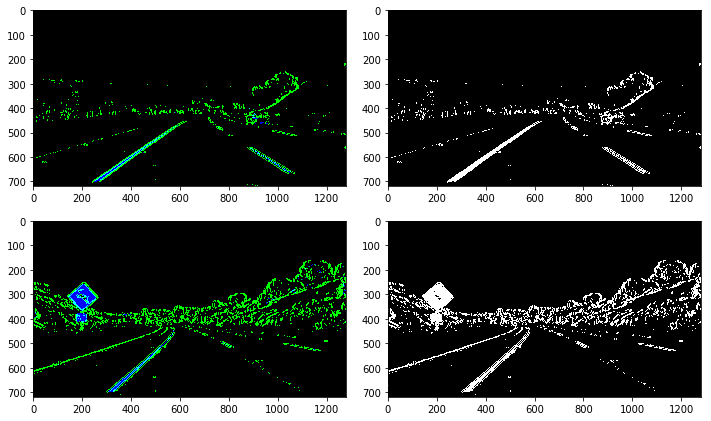

In [28]:
display_images_compare(color_binary_imgs[0:2], combined_binary_imgs[0:2])

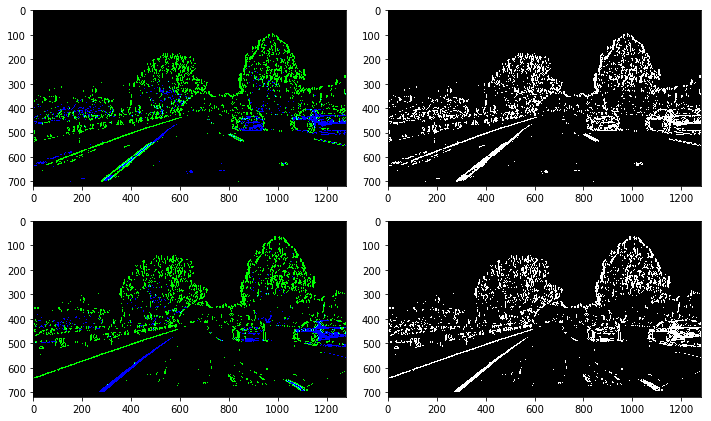

In [29]:
display_images_compare(color_binary_imgs[2:4], combined_binary_imgs[2:4])

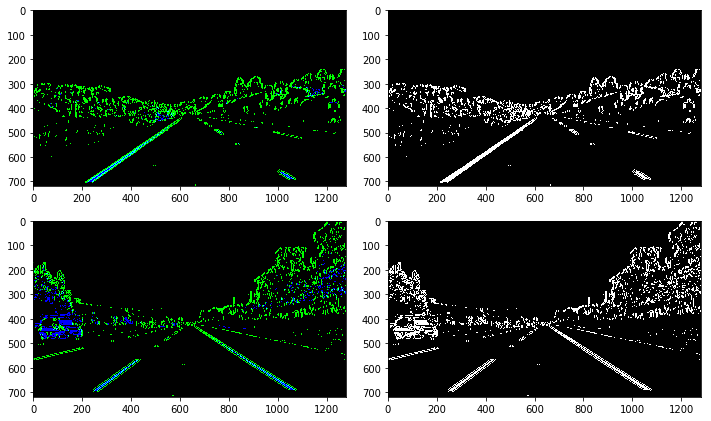

In [30]:
display_images_compare(color_binary_imgs[4:6], combined_binary_imgs[4:6])

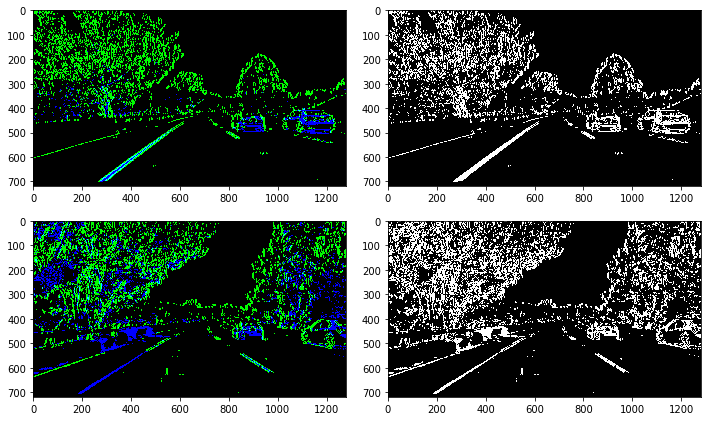

In [31]:
display_images_compare(color_binary_imgs[6:8], combined_binary_imgs[6:8])

## Perspective Transform

### Find trapezoid coordinates

In [32]:
#find source points on straight images
straight_images = glob.glob('test_images/straight*.jpg')
processed_straight_images = []
for fname in straight_images:
    img = cv2.imread(fname)
    img = bgr2rgb(img)
    processed_straight_images.append(img)    

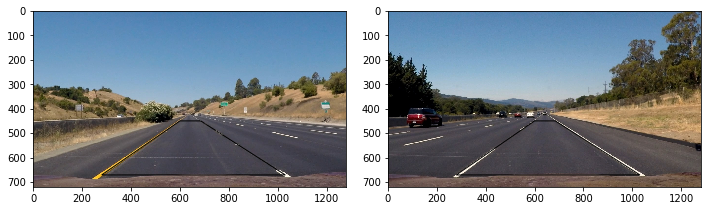

In [33]:
plt.rcParams['figure.figsize'] = [10,6]
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
    
# Trapezoid
x = [280,600,685,1031]
y = [671,450,450,671]

# Display the image
axes[0].imshow(processed_straight_images[0])
axes[1].imshow(processed_straight_images[1])

axes[0].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
axes[1].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))

plt.show()

### Compute Transform

In [34]:
src = np.float32([
    [280, 671],
    [600, 450],
    [685, 450],
    [1031, 671]
])

dst = np.float32([
    [280, 671],
    [280, 0],
    [1031, 0],
    [1031, 671]
])
    
perspective_transform = cv2.getPerspectiveTransform(src, dst)    
inverse_perspective_transform = cv2.getPerspectiveTransform(dst, src)

In [35]:
def get_warped(image):
    img_size = (image.shape[1], image.shape[0])    
    warped = cv2.warpPerspective(image, perspective_transform, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [36]:
transformed_imgs = []
for image in combined_binary_imgs:
    transformed_imgs.append(get_warped(image))

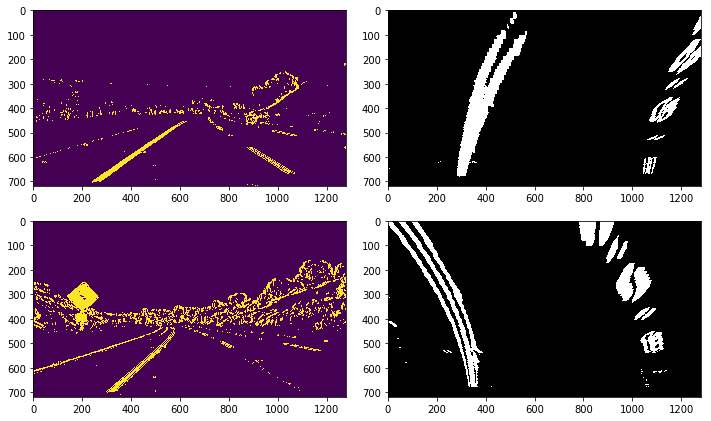

In [37]:
display_images_compare(combined_binary_imgs[0:2], transformed_imgs[0:2])

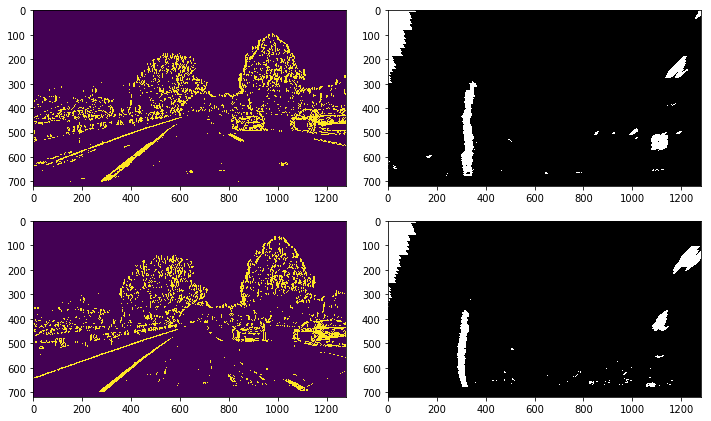

In [38]:
display_images_compare(combined_binary_imgs[2:4], transformed_imgs[2:4])

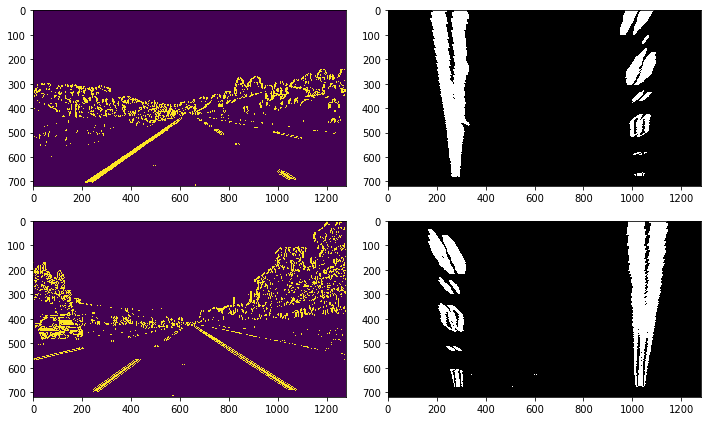

In [39]:
display_images_compare(combined_binary_imgs[4:6], transformed_imgs[4:6])

## Lanes Detection

In [86]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):
        self._n_iterations = 10        
        # was the line detected in the last iteration?
        self._detected = False  
        
        # x values of the last n fits of the line
        self._recent_xfitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self._best_fit = []
            #polynomial coefficients for the most recent fit
        self._current_fit = None

        #radius of curvature of the line in meters
        self._radius_of_curvature = None 

        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

        #x values for detected line pixels
        self._allx = None  

        #y values for detected line pixels
        self._ally = None


    @property
    def recent_xfitted(self):
        return self._recent_xfitted

    @recent_xfitted.setter
    def recent_xfitted(self, value): 
        if len(self._recent_xfitted) >= self._n_iterations:
            self._recent_xfitted.pop(0)
        self._recent_xfitted.append(value)

    #average x values of the fitted line over the last n iterations
    @property
    def bestx(self):
        if len(self._recent_xfitted) >= 0:
            return sum(self._recent_xfitted) / float(len(self._recent_xfitted))
        return self._recent_xfitted

        
    #polynomial coefficients averaged over the last n iterations
    @property
    def best_fit(self):
        if len(self._best_fit) > 0:
            return sum(self._best_fit) / float(len(self._best_fit))
        return self._best_fit

    #polynomial coefficients over the last n iterations
    @best_fit.setter
    def best_fit(self, value):
        if len(self._best_fit) > self._n_iterations:
            self._best_fit.pop(0)
        self._best_fit.append(value)
                     

    @property
    def current_fit(self):  
        return self._best_fit[-1]

    @property
    def radius_of_curvature(self):        
        return self._radius_of_curvature        

    @radius_of_curvature.setter
    def radius_of_curvature(self, value):            
        self._radius_of_curvature = value
        
    @property
    def allx(self):        
        return self._allx        

    @allx.setter
    def allx(self, value):            
        self._allx = value

    @property
    def ally(self):        
        return self._ally        

    @ally.setter
    def ally(self, value):            
        self._ally = value
        
    @property
    def detected(self):
        if np.sum(self.ally) < 3000:
            self._detected = False
            return False
        self._detected = True
        return True


In [159]:
l_line = Line()
r_line = Line()

### Histogram Line Detection

In [154]:
#Processes the image and finds polynomials that fit the left and right lane
#Search the whole window
def find_lane_all_windows(warped, return_image = False):
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 100

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Create an output image to draw on and  visualize the result
    if return_image:
        out_img = np.dstack((warped, warped, warped))*255

    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)


    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base


    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        if return_image:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    if return_image:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    l_line.allx = leftx
    l_line.ally = lefty    
    l_line.best_fit = left_fit
    
    r_line.allx = rightx
    r_line.ally = righty
    r_line.best_fit = right_fit
    
    if return_image:    
        return out_img

In [151]:
#Calculates curvature in meters
def find_radius_meters(image, use_best_fit=True):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    y_eval = np.max(ploty)
    y_max = image.shape[1]

    if use_best_fit:
        l_fit = l_line.best_fit
        r_fit = r_line.best_fit
    else:
        l_fit = l_line.current_fit
        r_fit = r_line.current_fit

    left_curverad = ((1 + (2*l_fit[0]*y_eval + l_fit[1])**2)**1.5) / np.absolute(2*l_fit[0])
    right_curverad = ((1 + (2*r_fit[0]*y_eval + r_fit[1])**2)**1.5) / np.absolute(2*r_fit[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(l_line.ally*ym_per_pix, l_line.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(r_line.ally*ym_per_pix, r_line.allx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    l_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / \
                    np.absolute(2*left_fit_cr[0])
    r_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / \
                    np.absolute(2*right_fit_cr[0])
    
    # Center and offset
    left_int = l_fit[0] * y_max ** 2 + l_fit[1] * y_max + l_fit[2]
    right_int = r_fit[0] * y_max ** 2 + r_fit[1] * y_max + r_fit[2]

    center = (left_int + right_int) / 2    
    offset = (center - 640) * xm_per_pix
    
    return offset   
    

In [152]:
def project_lines_and_data_on_image(original_image, warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    img_size = (original_image.shape[1], original_image.shape[0])    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_perspective_transform, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

left curvature 774.142993074 m
right curvature 721.148960944 m
-0.122401923715 m


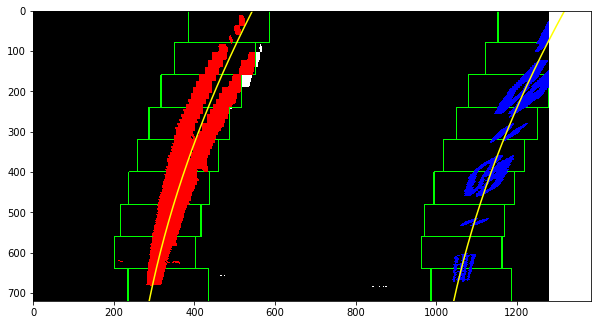

left curvature 401.610838184 m
right curvature 330.927307005 m
-0.191547584376 m


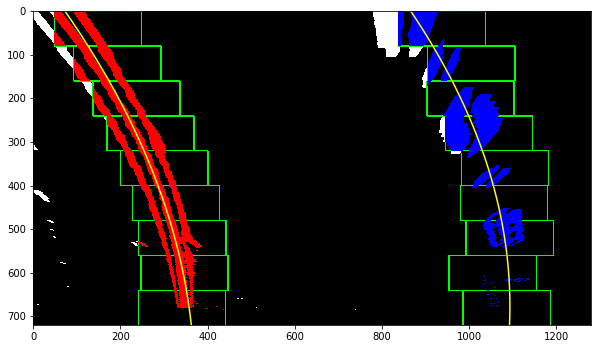

left curvature 653.844053303 m
right curvature 534.722908256 m
0.875058028342 m


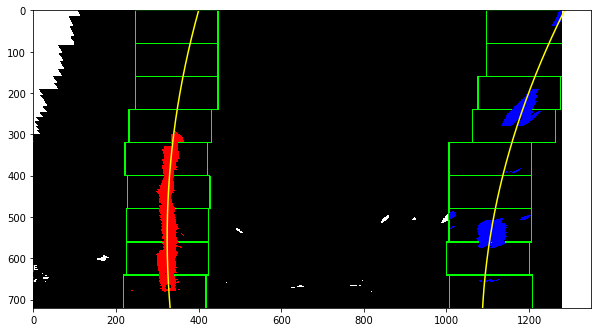

left curvature 284.983038181 m
right curvature 257.914023796 m
1.80958010164 m


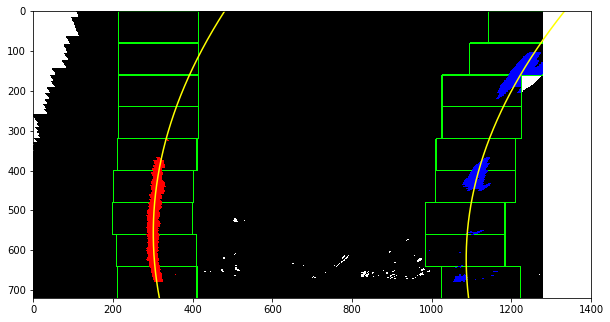

left curvature 5591.04344276 m
right curvature 942.812168423 m
-0.289786325277 m


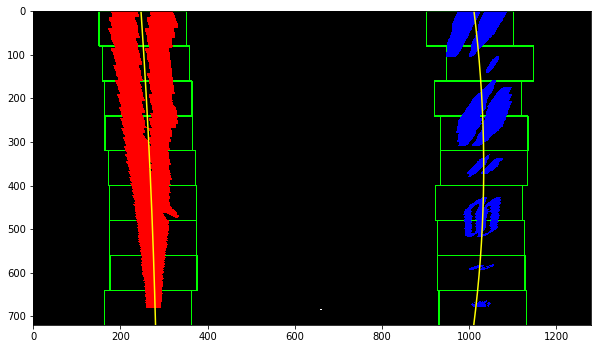

left curvature 797.257955933 m
right curvature 2896.36025971 m
-0.394046485582 m


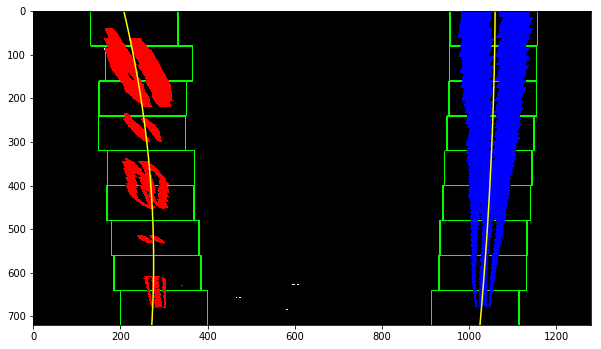

left curvature 1208.93848631 m
right curvature 2165.7461565 m
-0.722474423415 m


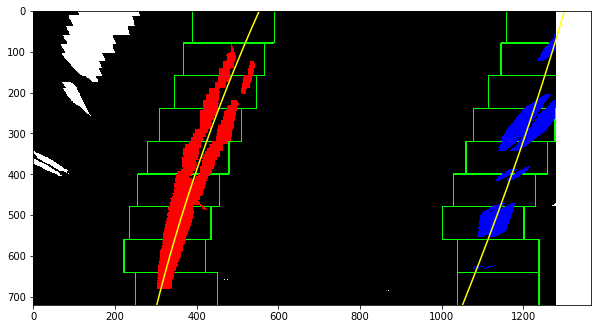

left curvature 220.006539463 m
right curvature 319.720722931 m
1.49854338948 m


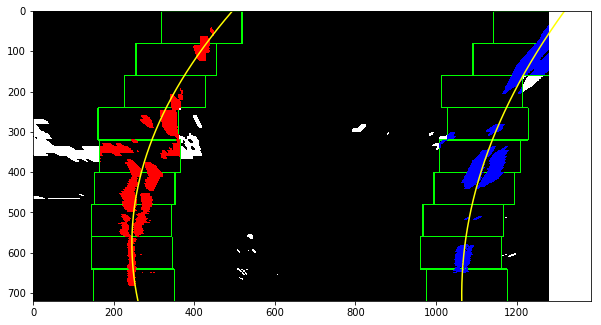

In [153]:
#perform search across all windows
l_line = Line()
r_line = Line()

for warped in transformed_imgs:
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    res_img = find_lane_all_windows(warped, True)    
    
    left_fitx = l_line.current_fit[0]*ploty**2 + l_line.current_fit[1]*ploty + l_line.current_fit[2]
    right_fitx = r_line.current_fit[0]*ploty**2 + r_line.current_fit[1]*ploty + r_line.current_fit[2]
    
    plt.imshow(res_img)    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    offset = find_radius_meters(warped, use_best_fit = False)
    print('left curvature', l_line.radius_of_curvature, 'm')
    print('right curvature', r_line.radius_of_curvature, 'm')    
    print(offset, 'm')
    
    plt.show()  

In [155]:
def get_lane_data_overlay(original, warped, use_best_fit = True):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    find_lane_all_windows(warped)    
    
    if use_best_fit:
        l_fit = l_line.best_fit
        r_fit = r_line.best_fit
    else:
        l_fit = l_line.current_fit
        r_fit = r_line.current_fit
    
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    offset = find_radius_meters(warped, use_best_fit)
    left_c_str = "left curvature: " + str(round(l_line.radius_of_curvature, 2)) + "m"
    right_c_str = "right curvature: " + str(round(r_line.radius_of_curvature, 2)) + "m"
    offset_str = "vehicle is " + str(round(abs(offset),2)) + "m "
    if offset > 0:
        offset_str += "right "
    else:
        offset_str += "left "
    
    offset_str += "from center"
    
    img = project_lines_and_data_on_image(original, warped, ploty, left_fitx, right_fitx)
    cv2.putText(img,left_c_str, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2, cv2.LINE_AA)
    cv2.putText(img,right_c_str, (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2, cv2.LINE_AA)
    cv2.putText(img,offset_str, (10,90), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2, cv2.LINE_AA)
    return img


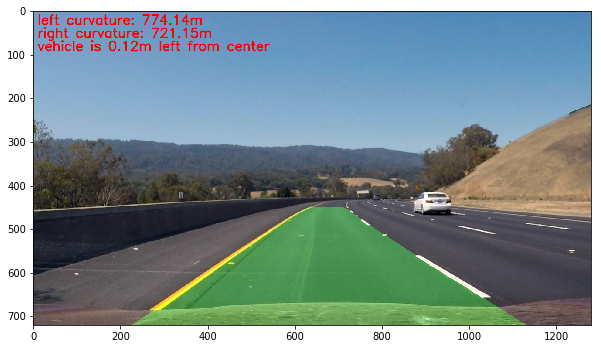

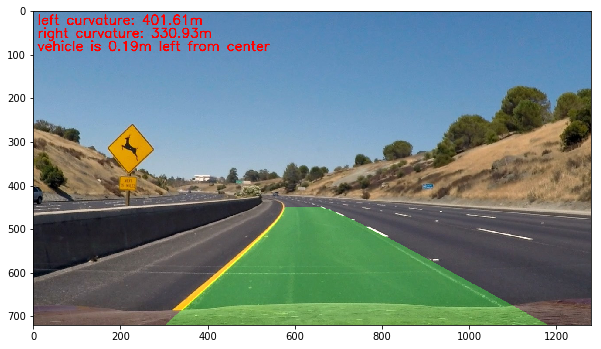

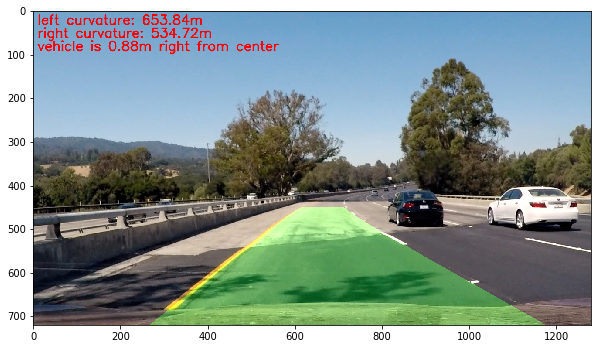

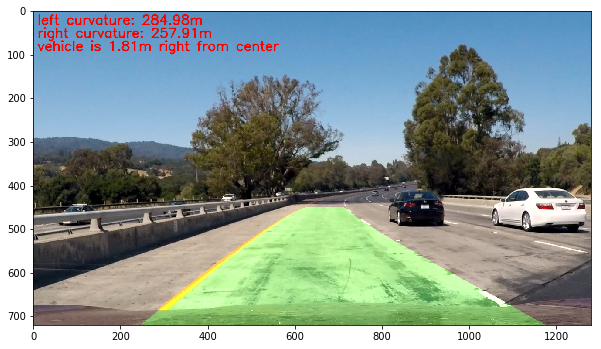

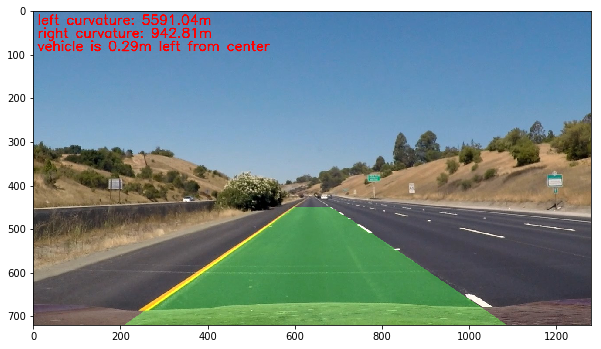

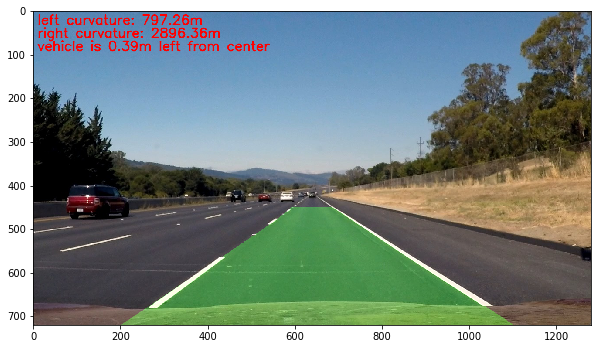

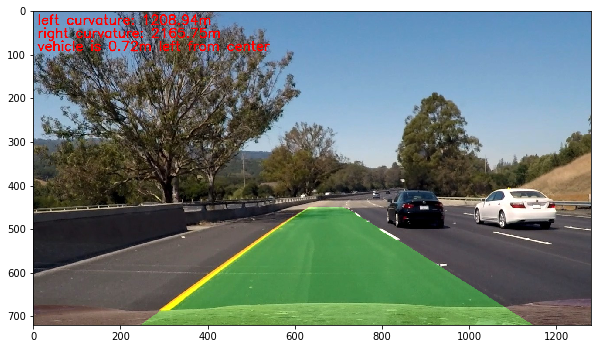

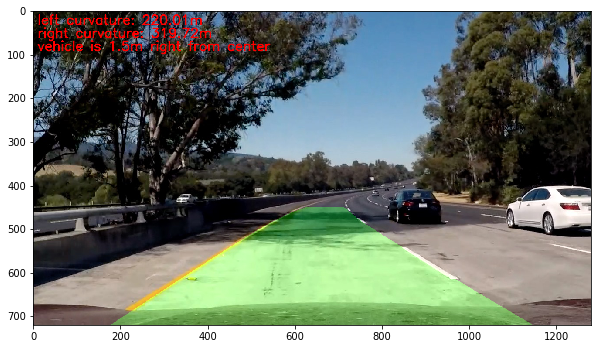

In [156]:
#perform search across all windows
l_line = Line()
r_line = Line()
for original, warped in zip(original_test_images, transformed_imgs):
    img = get_lane_data_overlay(original, warped, use_best_fit=False)
    plt.imshow(img)
    plt.show()

### Process Image - Complete Workflow

In [157]:
#Processes an RGB image by identifying the lane, left and right curvature, and vehicle offset from center
def process_image(image):
    undistorted = undistort(image) 
    
    threshold = get_cobmined_threshold(image)
    warped = get_warped(threshold)
    
    res_img = get_lane_data_overlay(image, warped)
    if not r_line.detected:
        print("Left line not detected")
    if not l_line.detected:
        print("Left line not detected")
        
    return res_img

In [158]:
#Process project video
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#save videos directory
save_dir = 'output_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

project_file = save_dir + 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(project_file, audio=False)

[MoviePy] >>>> Building video output_images/project_video_processed.mp4
[MoviePy] Writing video output_images/project_video_processed.mp4


100%|█████████▉| 1260/1261 [03:02<00:00,  7.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_processed.mp4 

CPU times: user 11min 47s, sys: 2.33 s, total: 11min 49s
Wall time: 3min 2s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_file))

In [160]:
#Process challenge video
#save videos directory
save_dir = 'output_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

challenge_file = save_dir + 'challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(challenge_file, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [01:06<00:00,  7.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 4min 23s, sys: 1.01 s, total: 4min 24s
Wall time: 1min 7s


In [161]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_file))

In [162]:
#Process challenge video
#save videos directory
save_dir = 'output_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

hard_challenge_file = save_dir + 'harder_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(hard_challenge_file, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|██████████| 485/485 [01:05<00:00,  6.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

CPU times: user 4min 21s, sys: 980 ms, total: 4min 22s
Wall time: 1min 6s


In [163]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hard_challenge_file))